In [1]:
import os 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
from PIL import Image
import nibabel as nib
from skimage.util import view_as_blocks

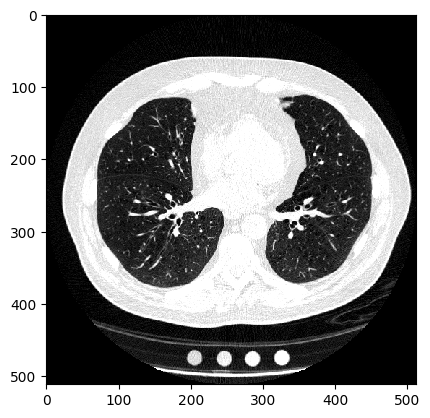

In [41]:
#load a NIfTI slice and plot it 
img = nib.load("/nfs/masi/krishar1/SPIE_2025_InhaleExhaleCT/data_split/train_slices/inspiratory_BONE/COPDGene_H16787_BONE_211.nii.gz").get_fdata()

#plot the image
plt.imshow(np.rot90(img[:,:,0]), cmap = 'gray', vmin = -1000, vmax=0)
plt.show()

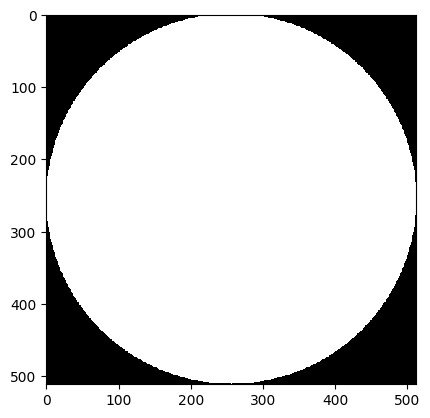

In [42]:
#Create a circular mask of the same size as the image
mask = np.zeros(img.shape)
width, height = img.shape[0], img.shape[1]
centx = width//2
centy = height//2

radius = min(centx, centy, width - centx, height - centy)
Y, X = np.ogrid[:height, :width]
dist_from_center = np.sqrt((X - centx)**2 + (Y-centy)**2)
mask = dist_from_center <= radius

#plot the mask
plt.imshow(np.rot90(mask), cmap = 'gray')
plt.show()

In [43]:
# Create a circular mask
def create_circular_mask(h, w, center=None, radius=None):
	if center is None:  # use the middle of the image
		center = (int(w/2), int(h/2))
	if radius is None:  # use the smallest distance between the center and image walls
		radius = min(center[0], center[1], w-center[0], h-center[1])

	Y, X = np.ogrid[:h, :w]
	dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)

	mask = dist_from_center <= radius
	return mask

# Load the NIfTI file
nifti_file = '/nfs/masi/krishar1/SPIE_2025_InhaleExhaleCT/data_split/train_slices/inspiratory_BONE/COPDGene_H16787_BONE_211.nii.gz'
nifti_data = nib.load(nifti_file)

# Extract image data
img = nifti_data.get_fdata()

# Assuming the image is 3D, select a single slice (e.g., the middle slice)
slice_index = img.shape[2] // 2
img_slice = img[:, :, slice_index]

# Create a circular mask
mask = create_circular_mask(*img_slice.shape)

# Apply the mask to the image slice
masked_img = img_slice * mask
masked_img[~mask] = -3024

masked_img_clipped = np.clip(masked_img, -1024, 3072)


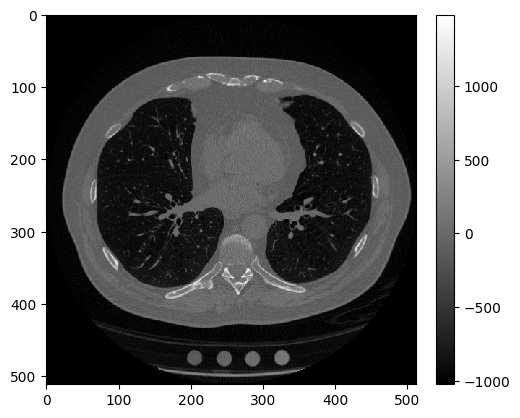

In [44]:
im = plt.imshow(np.rot90(masked_img_clipped), cmap = 'gray')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.show()

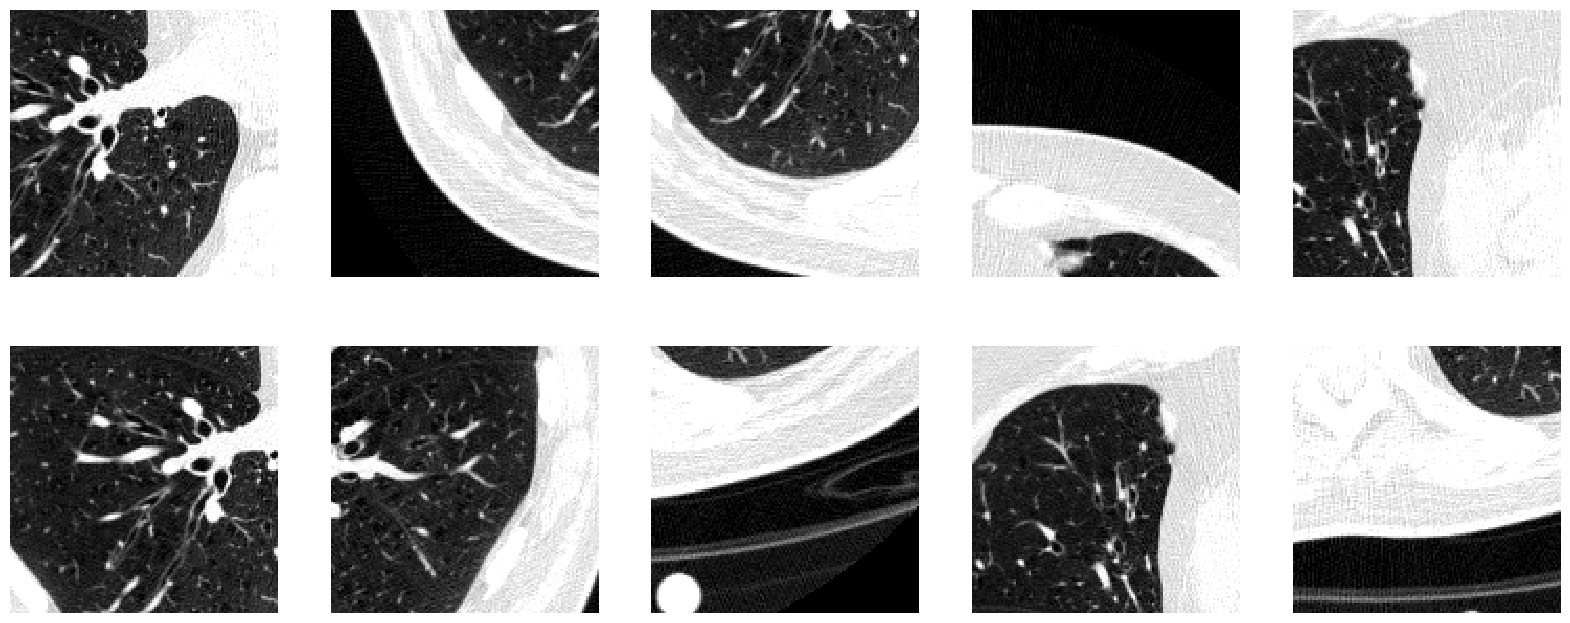

In [53]:
def random_crop(img, crop_size):
    h, w = img.shape
    y = np.random.randint(0, h - crop_size[0])
    x = np.random.randint(0, w - crop_size[1])
    return img[y:y + crop_size[0], x:x + crop_size[1]]

# Specify the number of patches you want
num_patches = 10

# Create a list to store the patches
patches = []

# Generate the patches
for _ in range(num_patches):
    patch = random_crop(masked_img_clipped, (128, 128))
    patches.append(patch)

# Plot the patches
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
for i in range(num_patches):
    ax[i // 5, i % 5].imshow(np.rot90(patches[i]), cmap='gray', vmin=-1000, vmax=0)
    ax[i // 5, i % 5].axis('off')

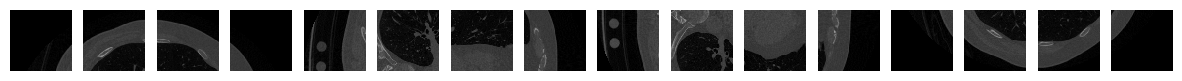

In [45]:
# Extract non-overlapping patches
patch_size = (128, 128)
patches = view_as_blocks(masked_img_clipped, block_shape=patch_size)

# Flatten the patches array
patches = patches.reshape(-1, *patch_size)

# Filter out patches that are completely zero (outside the circular region)
patches = [patch for patch in patches if np.any(patch)]

# Plot the patches
fig, axes = plt.subplots(1, len(patches), figsize=(15, 15))
for ax, patch in zip(axes, patches):
	ax.imshow(patch, cmap='gray', vmin = -1024, vmax = 3072)
	ax.axis('off')
plt.show()

In [46]:
len(patches)

16

In [47]:
# Assuming 'patches' is the list of patches and 'nifti_data' is the original NIfTI image
for i, patch in enumerate(patches):
    # Create a new NIfTI image
    patch_img = nib.Nifti1Image(patch, nifti_data.affine, nifti_data.header)

    # Save the patch as a NIfTI file
    nib.save(patch_img, os.path.join("/nfs/masi/krishar1/SPIE_2025_InhaleExhaleCT/data_split/patch_trial_data/bone",f'patch_{i}.nii.gz'))

## Patches for lung regions only from whole volumes 


In [ ]:
img = nib.load("/nfs/masi/krishar1/SPIE_2025_InhaleExhaleCT/data_split/train/inspiratory_BONE/COPDGene_G34421_BONE.nii.gz").get_fdata()
mask = nib.load("/nfs/masi/krishar1/SPIE_2025_InhaleExhaleCT/data_split/lungmasks/inspiratory_BONE/lung_mask/COPDGene_G34421_BONE.nii.gz").get_fdata()
